# Sprawozdanie - MOwNiT - laboratorium 4.

#### Autor: Jakub Psarski

## 1. Aproksymacja TSP z wykorzystaniem symulowanego wyżarzania

Wygeneruj chmurę n losowych punktów w 2D, a następnie zastosuj algorytm symulowanego wyżarzania do przybliżonego rozwiązania problemu komiwojażera dla tych punktów.
- Przedstaw wizualizację otrzymanego rozwiązania dla 3 różnych wartości n oraz 3 różnych układów punktów w 2D (rozkład jednostajny, rozkład normalny z czterema różnymi grupami parametrów, dziewięć odseparowanych grup punktów).
- Zbadaj wpływ sposobu generacji sąsiedniego stanu (consecutive swap vs. arbitrary swap) oraz funkcji zmiany temperatury na zbieżność procesu optymalizacji.
- Przedstaw wizualizację działania procedury minimalizującej funkcję celu.

### Importowanie potrzebnych bibliotek

In [36]:
import copy
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np

### Implementacja algorytmu symulowanego wyżarzania dla TSP

In [37]:
def simulated_annealing(
        points,
        temperature=100,
        temp_function=lambda x, _: x*0.995,
        threshold=1e-2,
        swap_type="arbitrary"
    ):
    """Solve TSP using simulated annealing."""
    point_amount = len(points)
    dist_matrix = distance_matrix(points)

    current_path = list(range(point_amount))
    random.shuffle(current_path)
    current_length = path_length(current_path, dist_matrix)

    initial_path = copy.deepcopy(current_path)
    initial_length = current_length

    best_path = copy.deepcopy(current_path)
    best_length = current_length
    found_time = t_0 = time.perf_counter()

    lengths = [(0, initial_length)]
    temps = [(0, temperature)]
    paths = [copy.deepcopy(initial_path)]

    while temperature > threshold:
        for _ in range(100):
            match swap_type:
                case "consecutive":
                    i = random.randint(0, point_amount - 2)
                    j = i + 1
                case "arbitrary":
                    i, j = random.sample(range(point_amount), 2)

            current_path[i], current_path[j] = current_path[j], current_path[i]
            new_length = path_length(current_path, dist_matrix)

            if new_length < current_length or random.random() < math.exp((current_length - new_length) / temperature):
                current_length = new_length

                if new_length < best_length:
                    best_path = copy.deepcopy(current_path)
                    best_length = new_length
                    found_time = time.perf_counter() - t_0

            else:
                current_path[i], current_path[j] = current_path[j], current_path[i]

            paths.append(copy.deepcopy(current_path))

            lengths.append((time.perf_counter() - t_0, current_length))

        timestamp = time.perf_counter() - t_0
        temperature = temp_function(temperature, timestamp)
        temps.append((timestamp, temperature))

    return best_path, best_length, found_time, initial_path, initial_length, lengths, temps, paths


### Funkcje pomocnicze

- `generate_points()` - generowanie chmury punktów zgodnie z podanymi parametrami

In [38]:
def generate_points(n, distribution="uniform"):
    """Generate n random points in 2D space with a given distribution."""
    match distribution:
        case "uniform":
            return np.random.rand(n, 2) * 100
        case "normal":
            centers = [(25, 25), (25, 75), (75, 25), (75, 75)]
            points = []
            for _ in range(n):
                center = random.choice(centers)
                points.append(np.random.normal(loc=center, scale=5, size=(1, 2))[0])
            return np.array(points)
        case "clusters":
            clusters = [(10, 10), (90, 90), (10, 90), (90, 10), (50, 50), (25, 75), (75, 25), (25, 25), (75, 75)]
            points = []
            for _ in range(n):
                cluster = random.choice(clusters)
                points.append(np.random.normal(loc=cluster, scale=2, size=(1, 2))[0])
            return np.array(points)

- `distance_matrix()` - generowanie macierzy zawierającej odległości między każdą parą punktów

In [39]:
def distance_matrix(points):
    """Compute the distance matrix for given points."""
    point_amount = len(points)
    dist_matrix = np.zeros((point_amount, point_amount))
    for i in range(point_amount):
        for j in range(point_amount):
            dist_matrix[i, j] = np.linalg.norm(points[i] - points[j])
    return dist_matrix

- `path_length()` - obliczanie długości danej drogi na podstawie macierzy odległości (funkcja kosztu)

In [40]:
def path_length(path, dist_matrix):
    """Calculate the total length of a given path."""
    return sum(dist_matrix[path[i], path[i + 1]] for i in range(len(path) - 1)) + dist_matrix[path[-1], path[0]]

- `plot_path()`, `plot_length()`, `plot_temperature()`, `plot_results()` - wizualizacja wyników oraz parametrów

In [41]:
def plot_path(ax, points, path, title):
    """Plot the given TSP path."""
    ordered_points = np.array([points[i] for i in path] + [points[path[0]]])
    ax.set_title(title)
    ax.plot(ordered_points[:, 0], ordered_points[:, 1], 'bo-')
    ax.scatter(points[:, 0], points[:, 1], c='red')


def plot_length(ax, lengths, title):
    """Plot the path lengths over iterations."""
    x_values, y_values = zip(*lengths)
    ax.plot(x_values, y_values, color='green', lw=0.5)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Path length")


def plot_temperature(ax, temps, title):
    """Plot the temperature over iterations."""
    x_values, y_values = zip(*temps)
    ax.plot(x_values, y_values, color='red', lw=1)
    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Temperature")


def plot_results(
        points,
        best_path,
        best_length,
        found_time,
        initial_path,
        initial_length,
        lengths, temps,
        n,
        dist,
        swap_type
    ):
    """Plot the results of the TSP simulation."""
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"TSP solution for n={n}, distribution: {dist}, swap type: {swap_type}", fontsize=16)

    plot_path(axs[0, 0], points, initial_path, title=f"Initial path: length = {initial_length:.2f}")
    plot_path(axs[0, 1], points, best_path,
              title=f"After annealing: length = {best_length:.2f}, found in {found_time:.2f}s")
    plot_length(axs[1, 0], lengths, title="Path length over iterations")
    plot_temperature(axs[1, 1], temps, title="Temperature over iterations")

    plt.show()

### Wyniki, czasy działania, wizualizacja

---------- n = 20 ----------

Distribution: uniform, swap type: arbitrary
Initial path length: 894.18
Best path length: 364.82, found in 0.88s
Total elapsed time: 2.82s


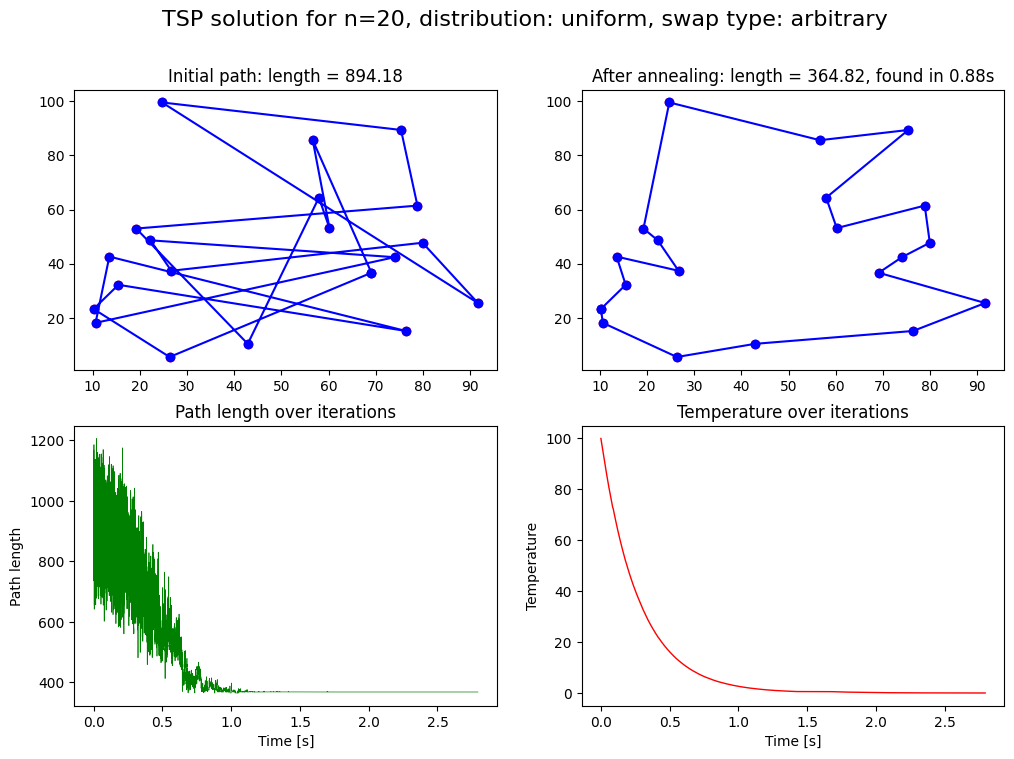

Distribution: uniform, swap type: consecutive
Initial path length: 999.05
Best path length: 428.92, found in 0.34s
Total elapsed time: 2.44s


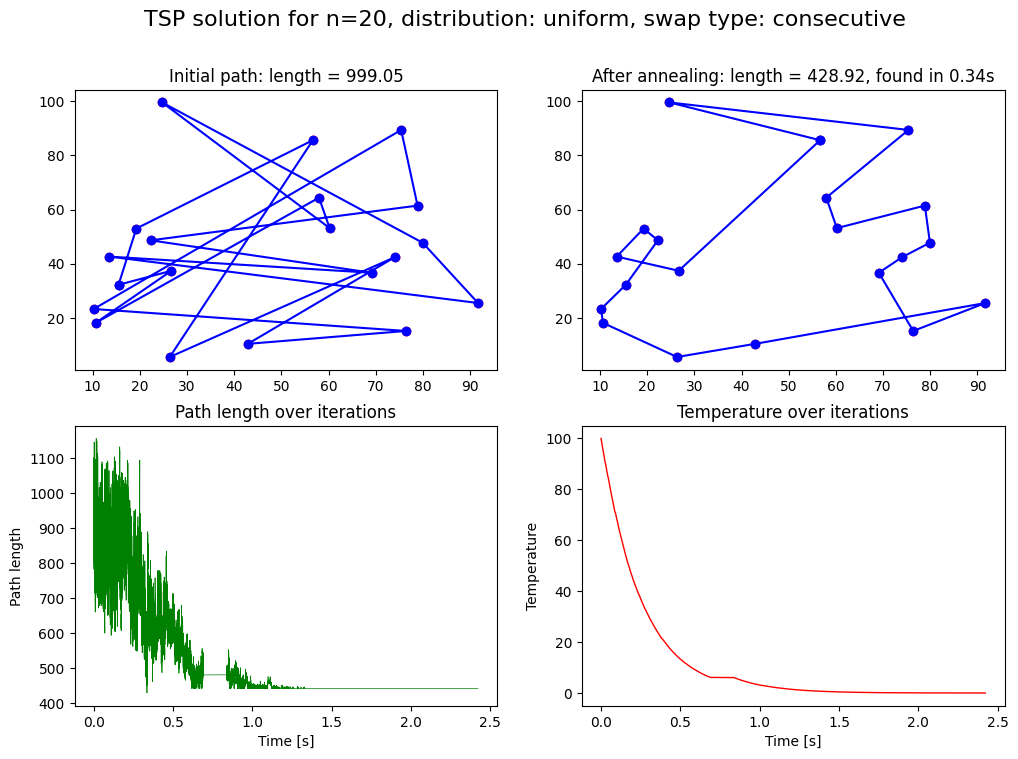

Shortest path comparison for different swap types:
arbitrary: 364.82
consecutive: 428.92

--------------------

Distribution: normal, swap type: arbitrary
Initial path length: 939.65
Best path length: 235.98, found in 1.18s
Total elapsed time: 2.70s


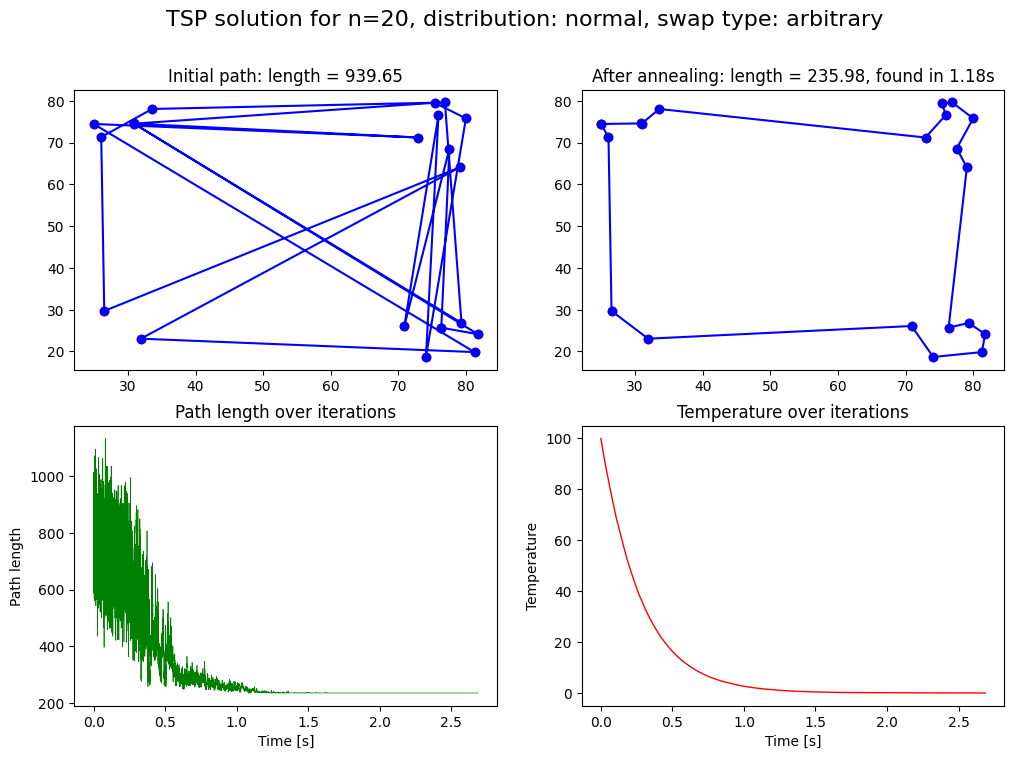

Distribution: normal, swap type: consecutive
Initial path length: 905.86
Best path length: 333.05, found in 0.33s
Total elapsed time: 2.49s


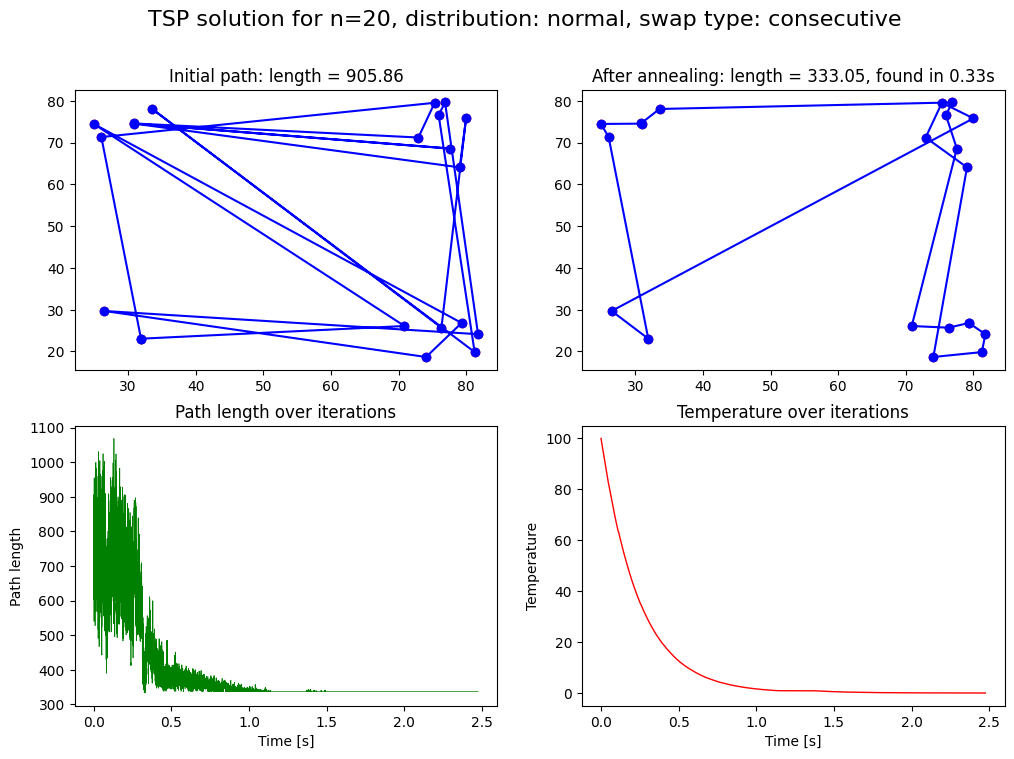

Shortest path comparison for different swap types:
arbitrary: 235.98
consecutive: 333.05

--------------------

Distribution: clusters, swap type: arbitrary
Initial path length: 993.65
Best path length: 344.97, found in 0.96s
Total elapsed time: 2.83s


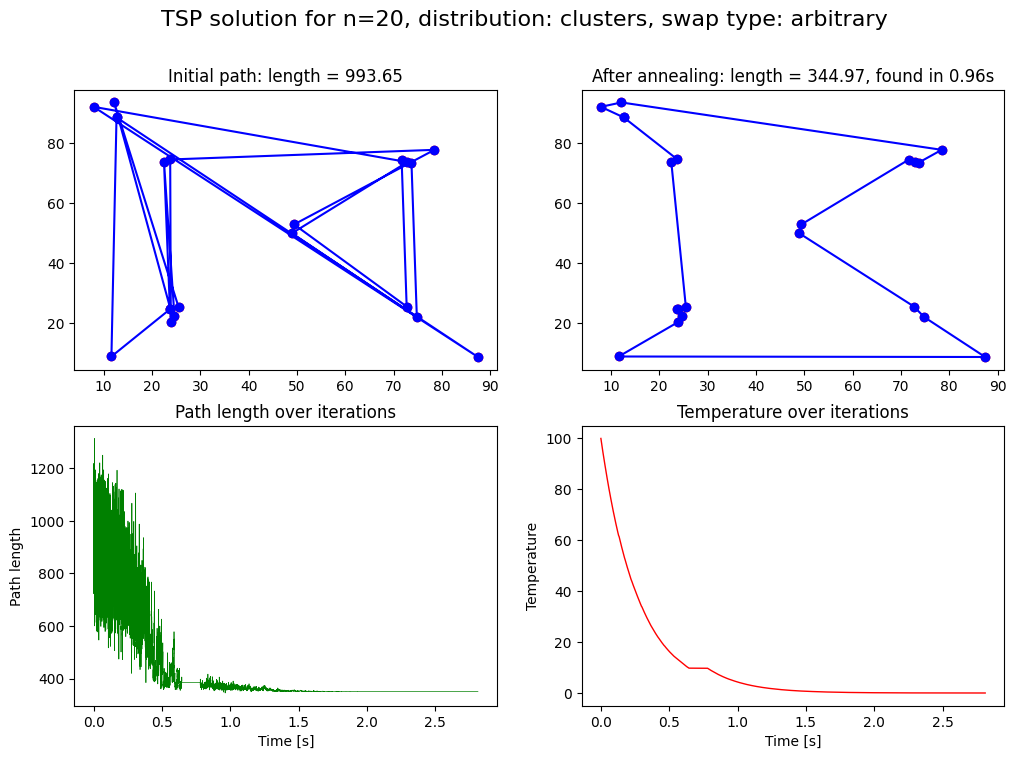

Distribution: clusters, swap type: consecutive
Initial path length: 942.98
Best path length: 424.83, found in 0.30s
Total elapsed time: 2.41s


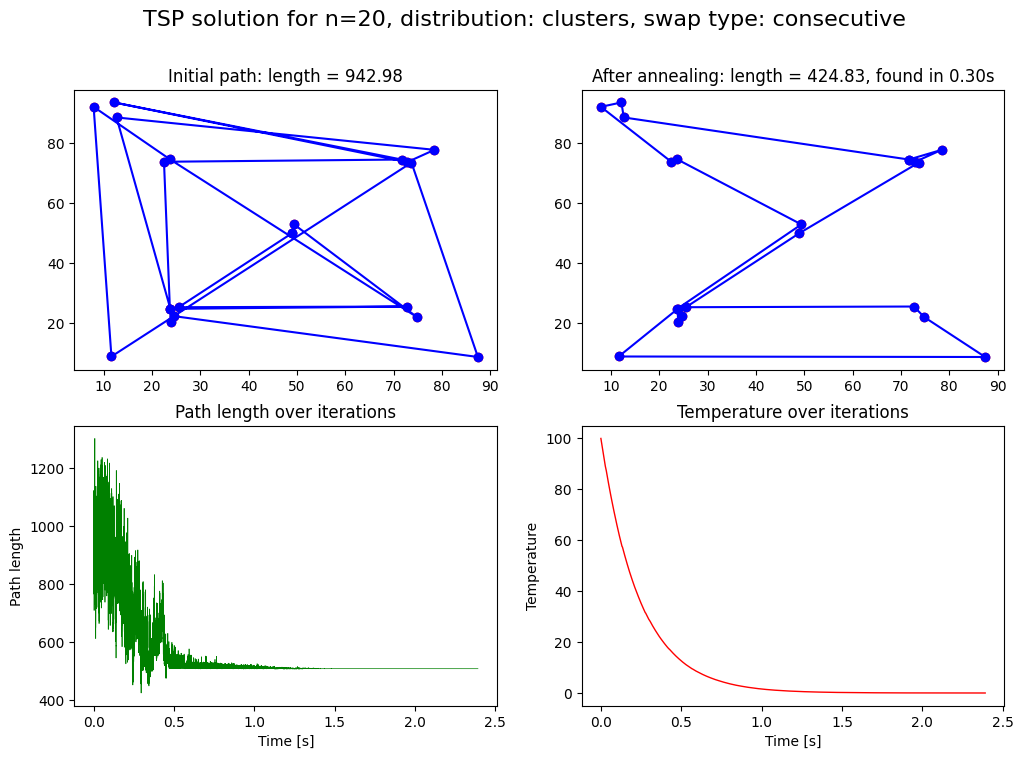

Shortest path comparison for different swap types:
arbitrary: 344.97
consecutive: 424.83

---------- n = 50 ----------

Distribution: uniform, swap type: arbitrary
Initial path length: 2914.34
Best path length: 651.49, found in 2.27s
Total elapsed time: 5.33s


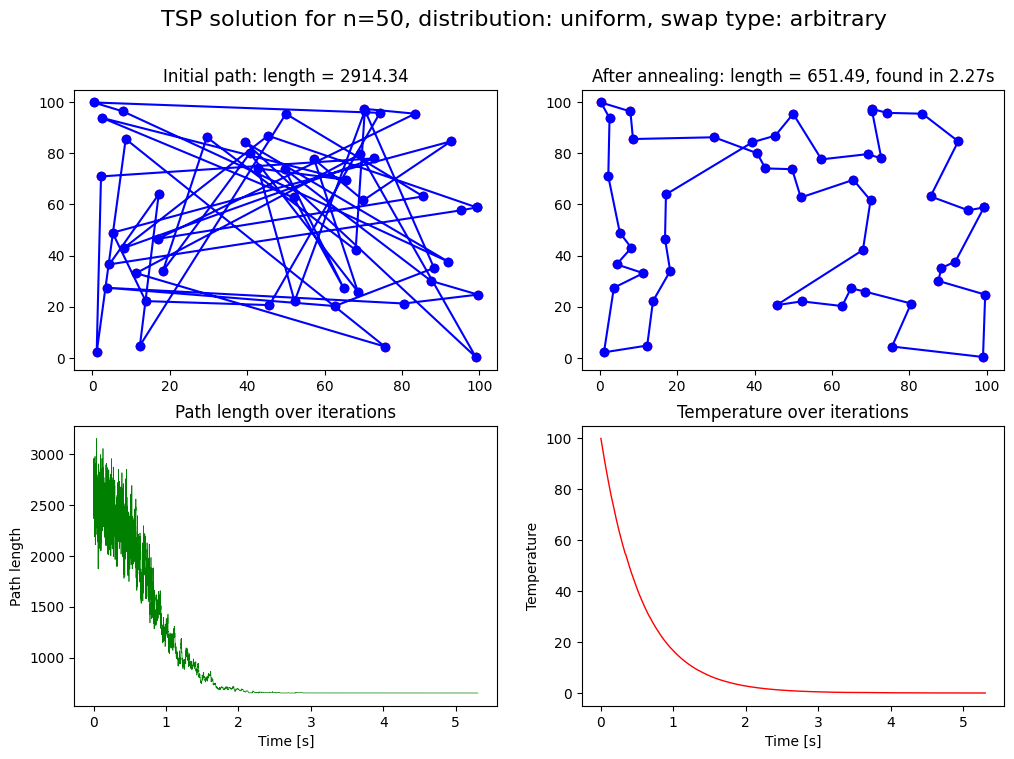

Distribution: uniform, swap type: consecutive
Initial path length: 3061.18
Best path length: 1230.35, found in 1.57s
Total elapsed time: 5.06s


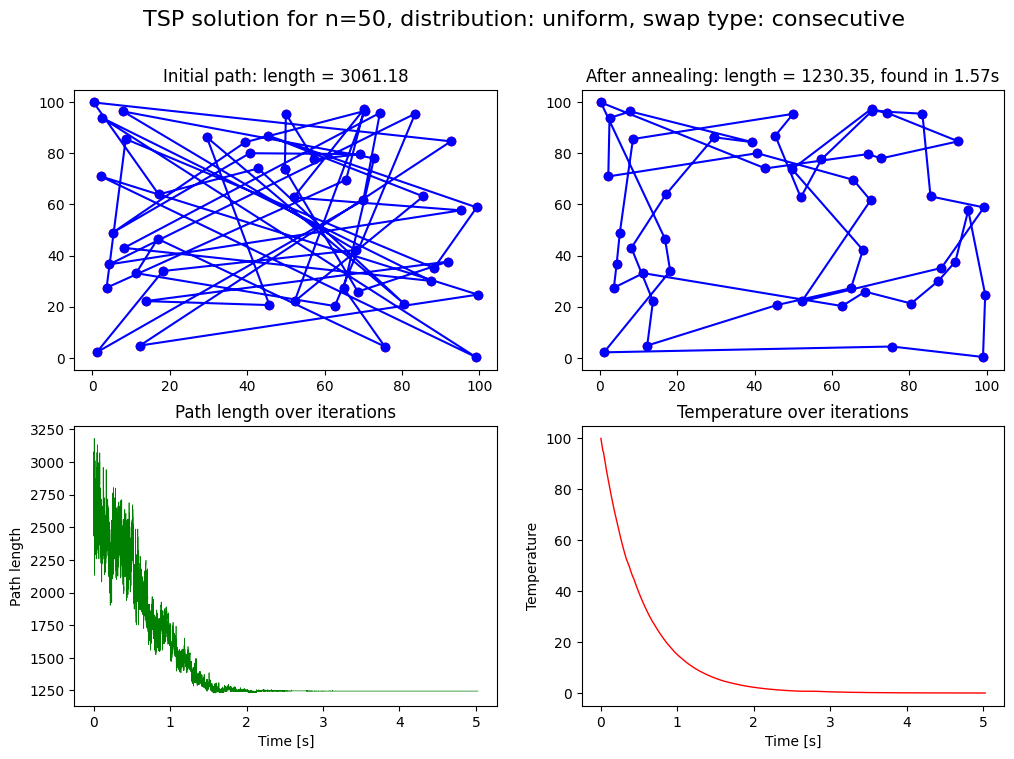

Shortest path comparison for different swap types:
arbitrary: 651.49
consecutive: 1230.35

--------------------

Distribution: normal, swap type: arbitrary
Initial path length: 2317.73
Best path length: 369.42, found in 3.48s
Total elapsed time: 5.47s


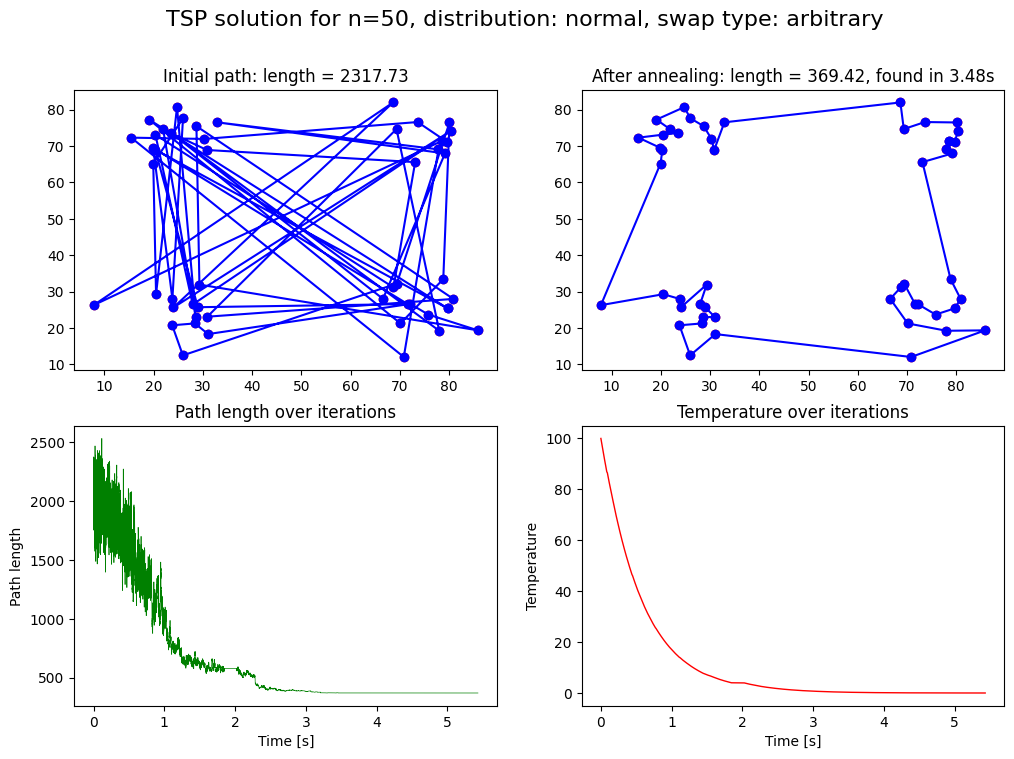

Distribution: normal, swap type: consecutive
Initial path length: 2357.07
Best path length: 877.88, found in 2.26s
Total elapsed time: 5.24s


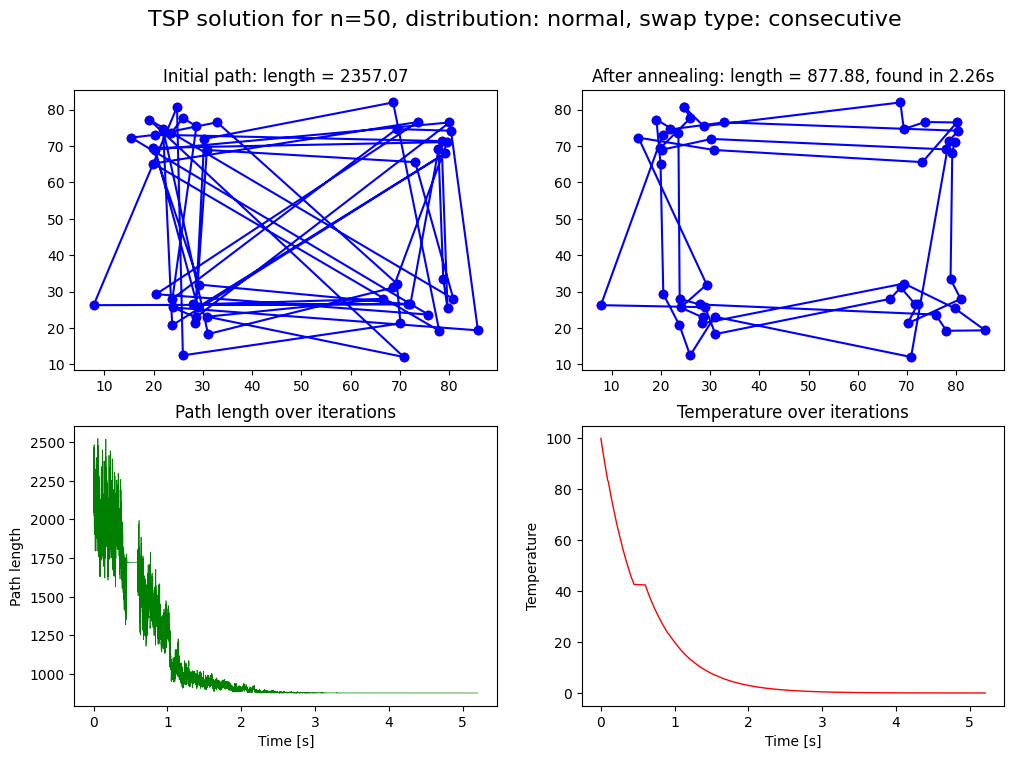

Shortest path comparison for different swap types:
arbitrary: 369.42
consecutive: 877.88

--------------------

Distribution: clusters, swap type: arbitrary
Initial path length: 2933.17
Best path length: 520.14, found in 3.79s
Total elapsed time: 5.45s


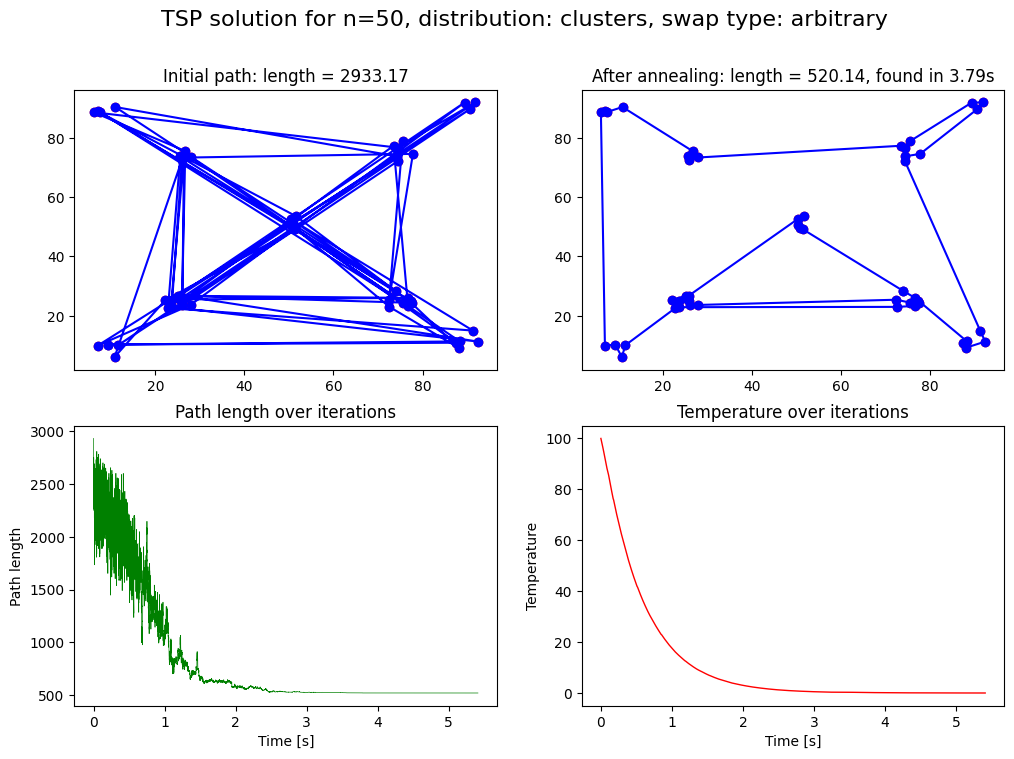

Distribution: clusters, swap type: consecutive
Initial path length: 2716.77
Best path length: 1037.41, found in 2.68s
Total elapsed time: 5.04s


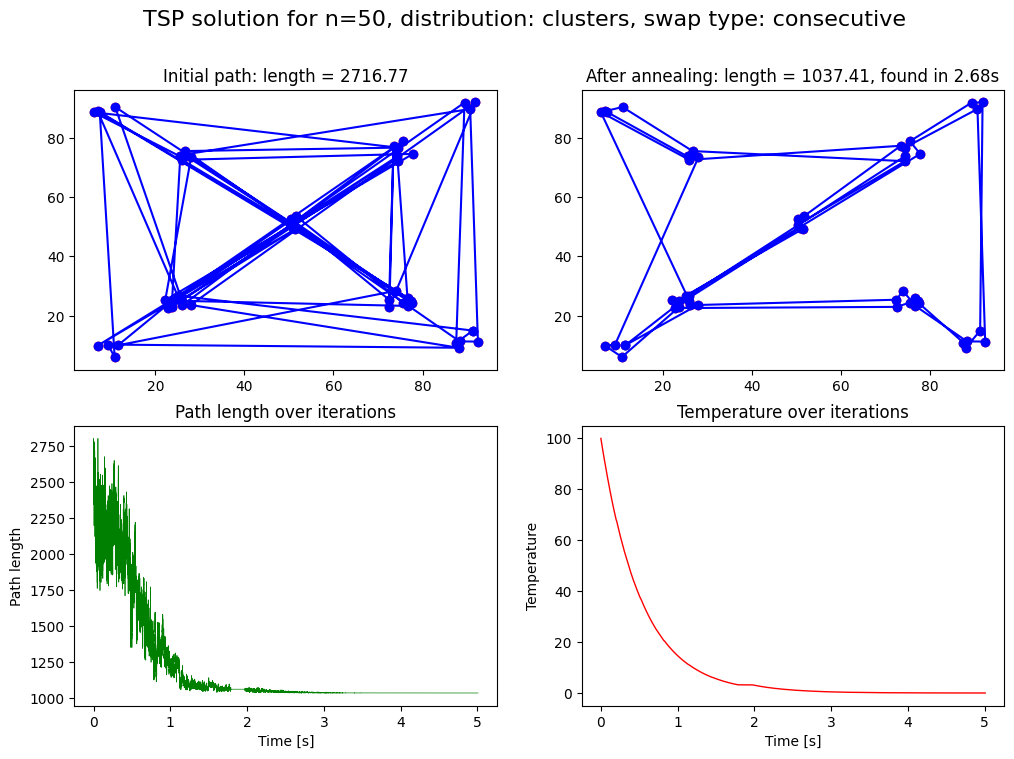

Shortest path comparison for different swap types:
arbitrary: 520.14
consecutive: 1037.41

---------- n = 100 ----------

Distribution: uniform, swap type: arbitrary
Initial path length: 5028.52
Best path length: 1163.80, found in 6.71s
Total elapsed time: 10.08s


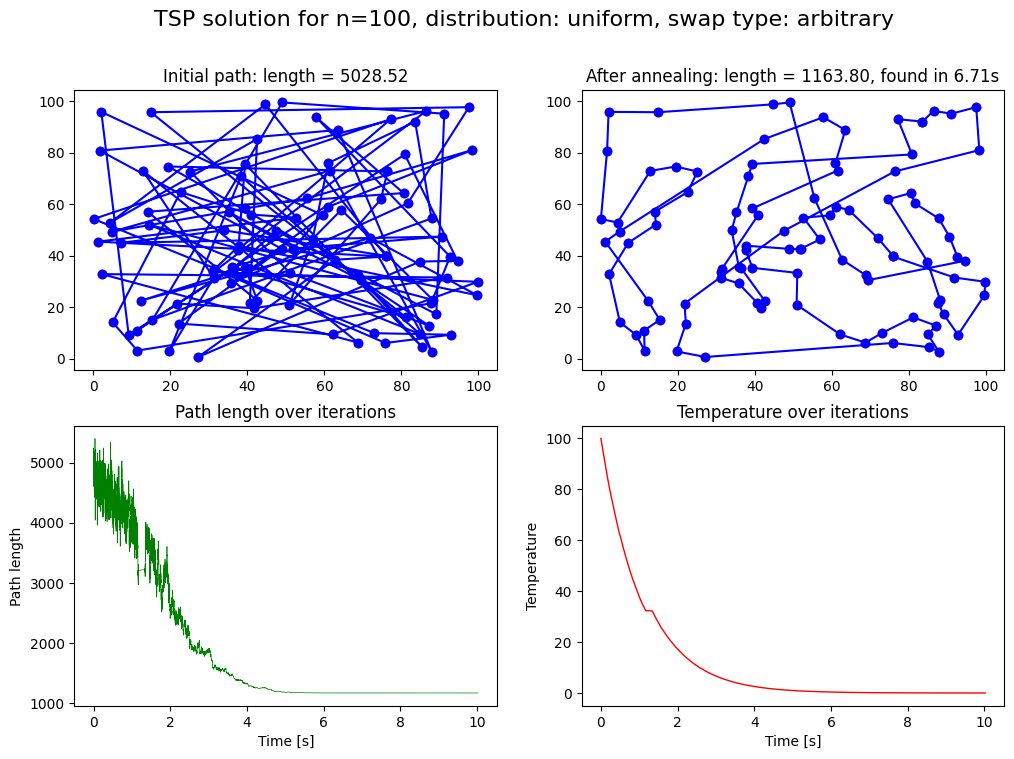

Distribution: uniform, swap type: consecutive
Initial path length: 4780.96
Best path length: 2514.24, found in 3.81s
Total elapsed time: 9.57s


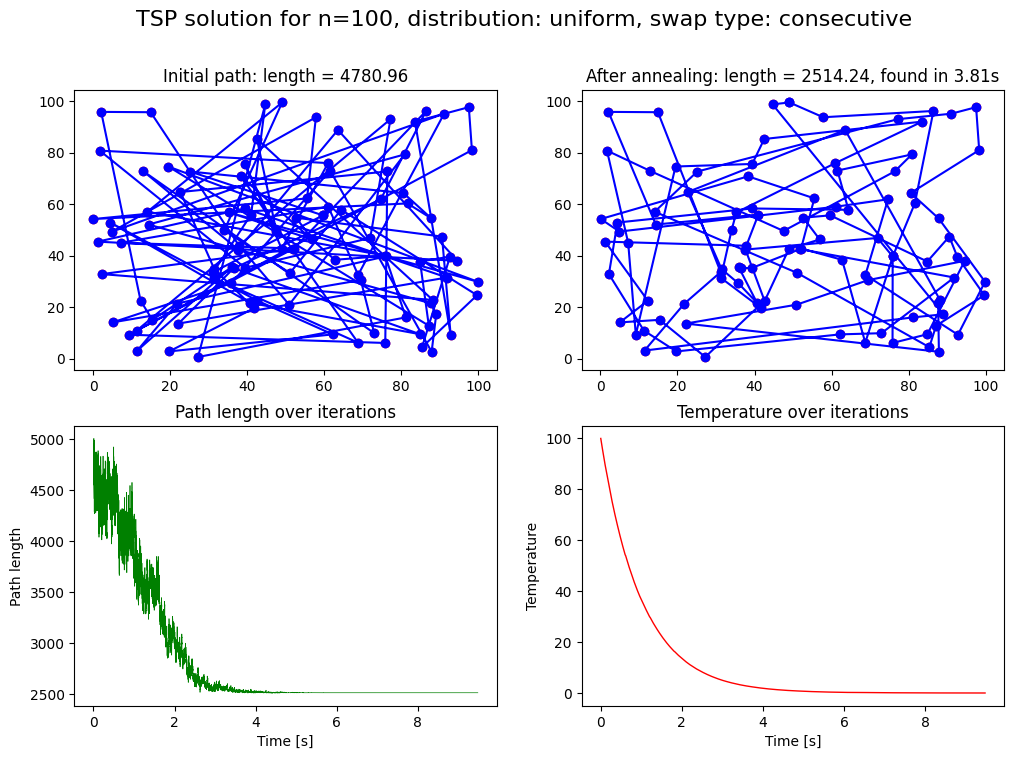

Shortest path comparison for different swap types:
arbitrary: 1163.80
consecutive: 2514.24

--------------------

Distribution: normal, swap type: arbitrary
Initial path length: 4349.07
Best path length: 782.31, found in 8.51s
Total elapsed time: 10.06s


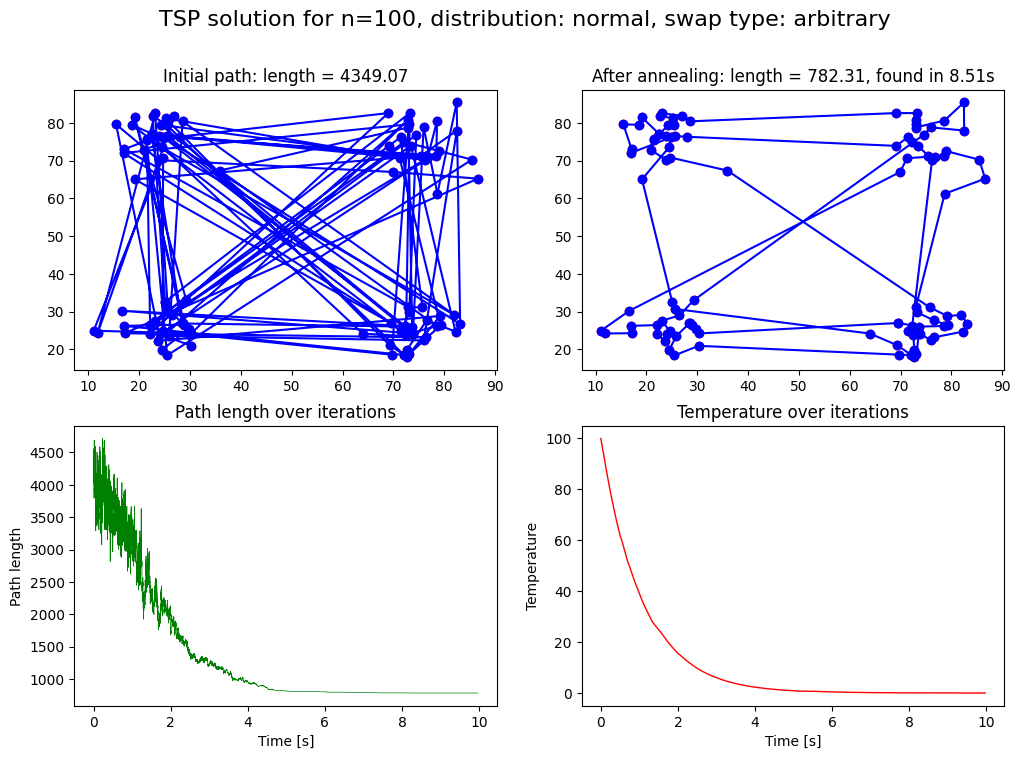

Distribution: normal, swap type: consecutive
Initial path length: 4522.63
Best path length: 1946.60, found in 6.17s
Total elapsed time: 9.54s


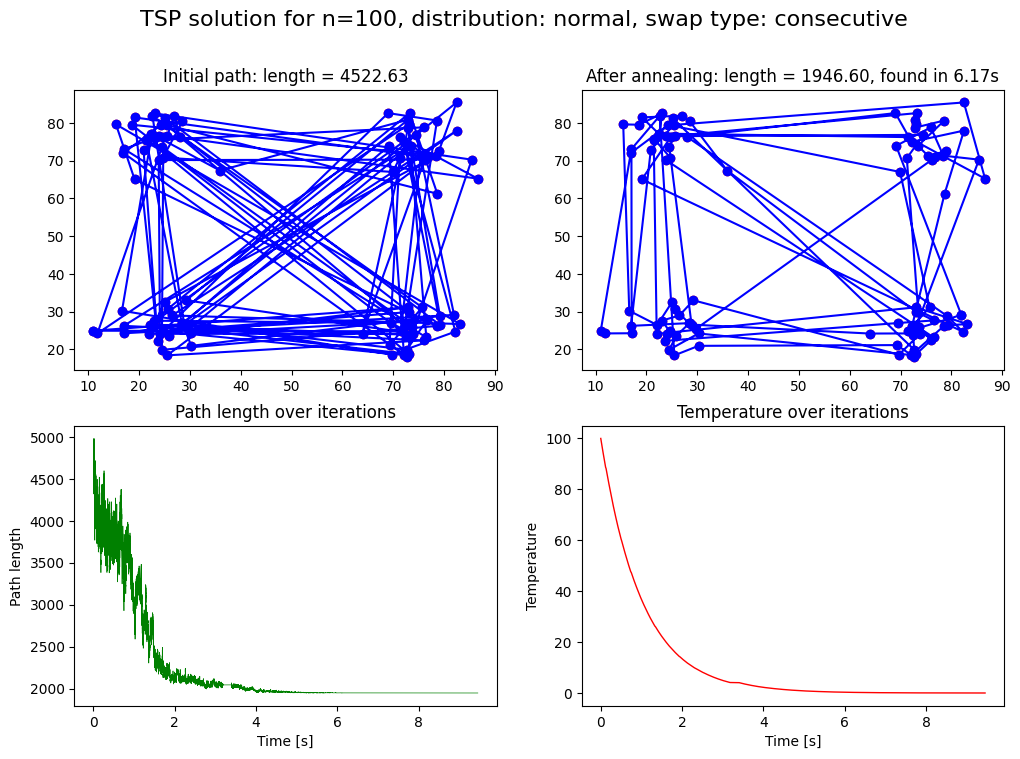

Shortest path comparison for different swap types:
arbitrary: 782.31
consecutive: 1946.60

--------------------

Distribution: clusters, swap type: arbitrary
Initial path length: 5736.62
Best path length: 734.51, found in 9.59s
Total elapsed time: 10.14s


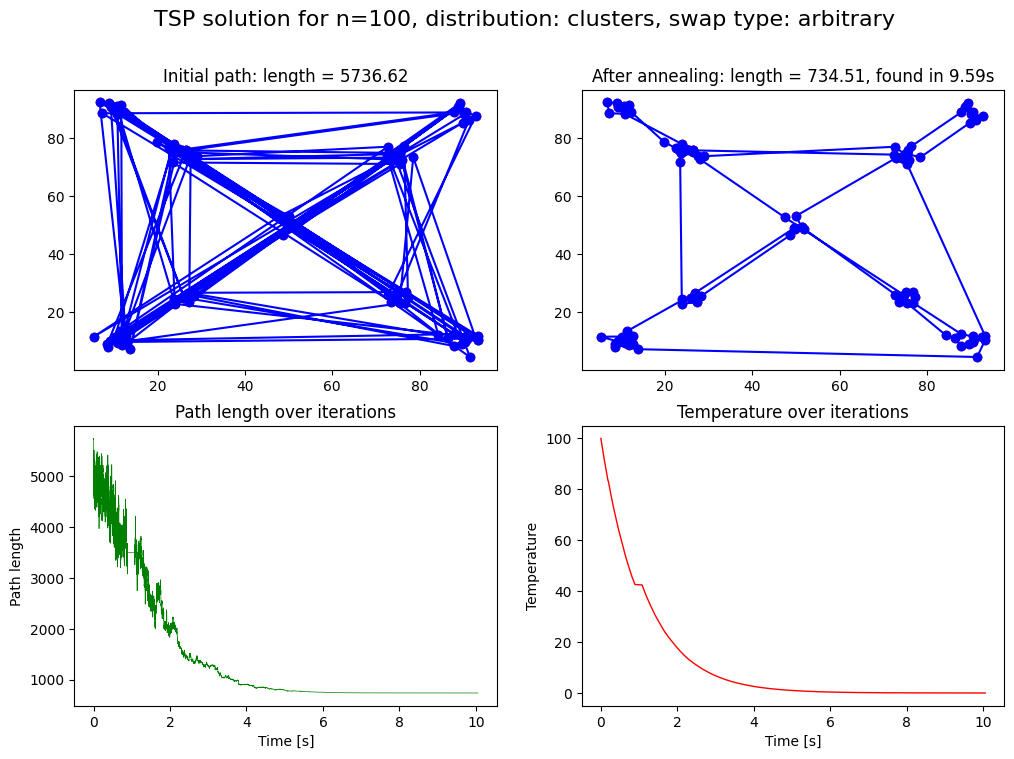

Distribution: clusters, swap type: consecutive
Initial path length: 5589.72
Best path length: 2590.98, found in 5.10s
Total elapsed time: 9.54s


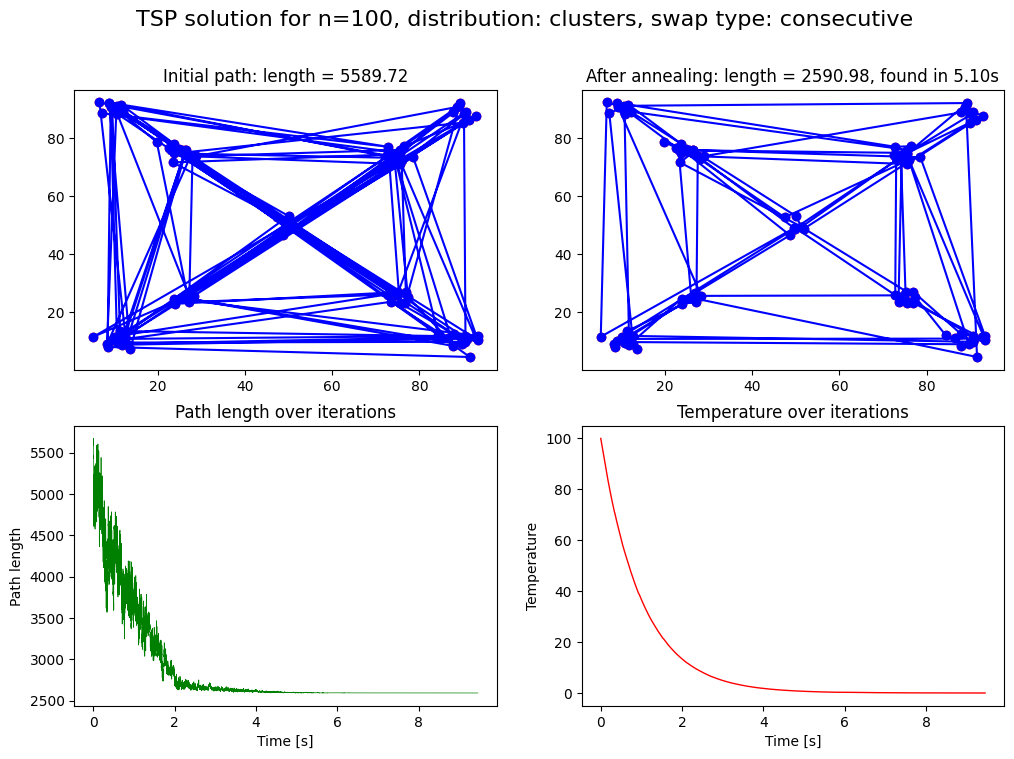

Shortest path comparison for different swap types:
arbitrary: 734.51
consecutive: 2590.98



In [42]:
n_values = [20, 50, 100]
distributions = ["uniform", "normal", "clusters"]
swap_types = ["arbitrary", "consecutive"]

for n in n_values:
    print(f"---------- n = {n} ----------\n")
    for dist in distributions:
        points = generate_points(n, dist)
        results = []
        for swap_type in swap_types:
            start = time.time()
            best_path, best_length, found_time, initial_path, initial_length, lengths, temps, paths =\
                simulated_annealing(points, swap_type=swap_type)
            elapsed = time.time() - start

            results.append((swap_type, best_length))

            print(f"Distribution: {dist}, swap type: {swap_type}")
            print(f"Initial path length: {initial_length:.2f}")
            print(f"Best path length: {best_length:.2f}, found in {found_time:.2f}s")
            print(f"Total elapsed time: {elapsed:.2f}s")

            plot_results(
                points,
                best_path,
                best_length,
                found_time,
                initial_path,
                initial_length,
                lengths,
                temps,
                n,
                dist,
                swap_type
            )

        print("Shortest path comparison for different swap types:") 
        for swap_type, best_length in results:
            print(f"{swap_type}: {best_length:.2f}")
        print()
        if dist != "clusters":
            print("--------------------\n")

## 2. Obraz binarny

Wygeneruj losowy obraz binarny o rozmiarze $n \times n$ i wybranej gęstości $δ$ czarnych punktów $δ = 0.1, 0.3, 0.4$. Korzystając z różnego typu sąsiedztwa (4-sąsiadów, 8-sąsiadów, 8-16-sąsiadów) zaproponuj funkcję energii (np. w bliskiej odległości te same kolory przyciągają się, a w dalszej odpychają się, funkcja energii może być również adaptacją modelu Isinga) i dokonaj jej minimalizacji za pomocą algorytmu symulowanego wyżarzania. W jaki sposób można generować stany sąsiednie? Jak różnią się uzyskane wyniki w zależności od rodzaju sąsiedztwa, wybranej funkcji energii i szybkości spadku temperatury?

## 3. Sudoku

Napisz program poszukujący rozwiązania łamigłówki Sudoku za pomocą symulowanego wyżarzania. Plansza $9 \times 9$ ma zostać wczytana z pliku tekstowego, w którym pola puste zaznaczone są znakiem `x`. Jako funkcję kosztu przyjmij sumę powtórzeń cyfr występujących w wierszach bloku $9 \times 9$, kolumnach bloku $9 \times 9$ oraz blokach $3 \times 3$. Zaproponuj metodę generacji stanu sąsiedniego. Przedstaw zależność liczby iteracji algorytmu od liczby pustych miejsc na planszy. Czy Twój program jest w stanie znaleźć poprawne rozwiązanie dla każdej z testowanych konfiguracji wejściowych?